In [46]:
import pandas as pd
import matplotlib.pyplot as plt


In [34]:
review_df = pd.read_csv("/content/labeledTrainData.tsv",
                       header = 0,
                       sep ='\t',
                       quoting = 3)
review_df.head(5)

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


**Data preprocessiong**

In [35]:
review_df.isna().sum()

id           0
sentiment    0
review       0
dtype: int64

In [36]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         25000 non-null  object
 1   sentiment  25000 non-null  int64 
 2   review     25000 non-null  object
dtypes: int64(1), object(2)
memory usage: 586.1+ KB


In [37]:
review_df.review[0]

'"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ\'s feeling towards the press and also the obvious message of drugs are bad m\'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally

In [38]:
import re
# replace <br/ > into blank
review_df['review'] = review_df['review'].replace('<br />',' ')

# replace the special letters and numbers into blank
review_df['review'] = review_df['review'].apply(lambda x : re.sub("[^a-zA-Z]"," ",x))

In [39]:
#split the data

from sklearn.model_selection import train_test_split
class_df = review_df['sentiment']
feature_df = review_df.drop(['id','sentiment'],axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(feature_df,class_df,
                                                    test_size = 0.3,
                                                    random_state = 156)

X_train.shape, X_test.shape

((17500, 1), (7500, 1))

In [40]:
from wordcloud import WordCloud,STOPWORDS
stopwords = set(STOPWORDS)


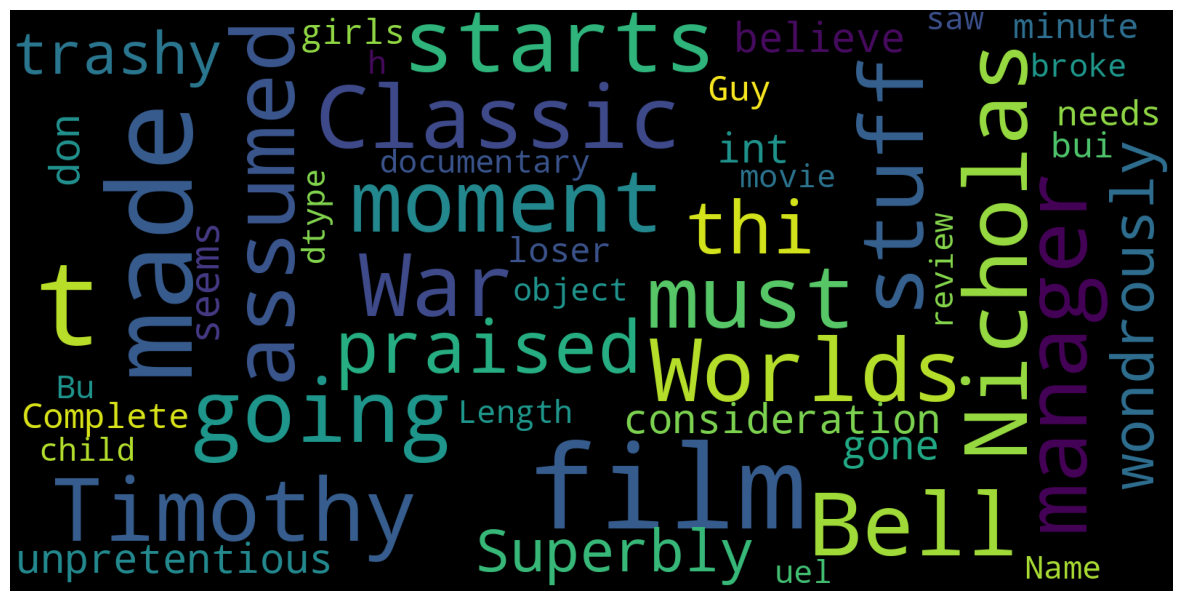

In [47]:
def generate_wordcloud(data, title = None):
    wordcloud = WordCloud(
        stopwords=stopwords,
        max_words=100,
        max_font_size=40,
        scale=4).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()

generate_wordcloud(review_df['review'])

**Bag of Words**

We will apply both count and TF-IDF vectorizer into logistic model.

In [42]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

# count vectorizer
pipeline = Pipeline([('cnt_vect',CountVectorizer(stop_words = 'english',ngram_range=(1,2))),
                     ('lr_clf', LogisticRegression())])

pipeline.fit(X_train['review'],y_train)
pred = pipeline.predict(X_test['review'])
pred_probs = pipeline.predict_proba(X_test['review'])[:,1]

print('Accuracy of count Vectorizer : {0:.4f}'.format(accuracy_score(y_test,pred)))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy of count Vectorizer : 0.8871


In [43]:
# TF-IDF vectorizer
pipeline = Pipeline([('tfidf_vect',TfidfVectorizer(stop_words = 'english',ngram_range=(1,2))),
                    ('lr_clf',LogisticRegression(C=10))])

pipeline.fit(X_train['review'],y_train)
pred = pipeline.predict(X_test['review'])
pred_probs = pipeline.predict_proba(X_test['review'])[:,1]

print('Accuracy of TF-IDF Vectorizer : {0:.4f}'.format(accuracy_score(y_test,pred)))

Accuracy of TF-IDF Vectorizer : 0.8932


TF-IDF vectorizer is more accurate than count vectorizer method.

**Hyperparameter**

In [44]:
max_df = [0.9,1.0]
C = [10,11,12]

for df in max_df:
    for c in C:
        pipeline = Pipeline([('tfidf_vect',TfidfVectorizer(stop_words = 'english',
                                                           ngram_range=(1,2),
                                                           max_df = df)),
                             ('lr_clf',LogisticRegression(C=c))])
        pipeline.fit(X_train['review'],y_train)
        pred = pipeline.predict(X_test['review'])

        print('max_df :{0}--- c :{1}, Accuracy : {2}'.format(df,c,accuracy_score(y_test,pred)))

max_df :0.9--- c :10, Accuracy : 0.8932
max_df :0.9--- c :11, Accuracy : 0.8936
max_df :0.9--- c :12, Accuracy : 0.8936
max_df :1.0--- c :10, Accuracy : 0.8932
max_df :1.0--- c :11, Accuracy : 0.8936
max_df :1.0--- c :12, Accuracy : 0.8936


In [49]:
import nltk
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk.stem import WordNetLemmatizer
from nltk.corpus import sentiwordnet as swn
from nltk import sent_tokenize, word_tokenize, pos_tag

def swn_polarity(text):
    sentiment = 0.0
    tokens_count = 0

    lemmatizer = WordNetLemmatizer()
    raw_sentences = sent_tokenize(text)

    for raw_sentence in raw_sentences:
        tagged_sentence = pos_tag(word_tokenize(raw_sentence))
        for word, tag in tagged_sentence:
            wn_tag = penn_to_wn(tag)
            if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
                continue
            lemma = lemmatizer.lemmatize(word, pos=wn_tag)
            if not lemma:
                continue

            synsets = wn.synsets(lemma, pos=wn_tag)

            if not synsets:
                continue
            synset = synsets[0]
            swn_synset = swn.senti_synset(synset.name())
            sentiment += (swn_synset.pos_score()-swn_synset.neg_score())
            tokens_count += 1
        if not tokens_count:
            return 0

        if sentiment >= 0 :
            return 1

    return 0

In [55]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('sentiwordnet')
review_df['preds'] = review_df['review'].apply(lambda x : swn_polarity(x))
y_target = review_df['sentiment'].values
preds = review_df['preds'].values

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.


In [59]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score
import numpy as np

print(confusion_matrix(y_target,preds))
print(np.round(accuracy_score(y_target, preds),10))
print(np.round(precision_score(y_target, preds),10))
print(np.round(recall_score(y_target, preds),10))

[[7669 4831]
 [3644 8856]]
0.661
0.6470373347
0.70848


In [61]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
senti_analyzer = SentimentIntensityAnalyzer()
senti_score = senti_analyzer.polarity_scores(review_df['review'][0])
print(senti_score)

{'neg': 0.127, 'neu': 0.747, 'pos': 0.125, 'compound': -0.7943}


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [62]:
def vader_polarity(review, threshold = 0.1):
    analyzer = SentimentIntensityAnalyzer()
    score = senti_analyzer.polarity_scores(review)

    agg_score = score['compound']
    final_sentiment = 1 if agg_score >= threshold else 0
    return final_sentiment

review_df['vader_preds'] = review_df['review'].apply(lambda x : vader_polarity(x, 0.1))
y_target = review_df['sentiment'].values
vader_preds = review_df['vader_preds'].values

print(confusion_matrix(y_target,vader_preds))
print(np.round(accuracy_score(y_target, vader_preds),4))
print(np.round(precision_score(y_target, vader_preds),4))
print(np.round(recall_score(y_target, vader_preds),4))

[[ 6749  5751]
 [ 1856 10644]]
0.6957
0.6492
0.8515
